## Uplift modeling experiments on CRITEO-UPLIFTv2 dataset

This code aims to:
- Show how to open and preprocess dataset
- Reproduce Table 3
- Reproduce Figure 3

In [ ]:
# ! pip install iterative-stratification

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import joblib

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize, OrdinalEncoder, OneHotEncoder

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns
%matplotlib inline

/Users/ulianavinogradova/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from tqdm.notebook import tqdm

In [3]:
from um_util import *
# from um_models import *

%load_ext autoreload
%autoreload 2

In [4]:
def get_coef_significance(X, Y):    
    X_train = sm.tools.tools.add_constant(X.values.astype(np.float64), prepend=True, has_constant='skip')
    
    Y_train = Y
#     log_reg = sm.Logit(Y_train, X_train).fit()
    lin_reg = sm.OLS(Y_train, X_train).fit()
    summary = lin_reg.summary().tables[1]
    return pd.read_html(summary.as_html(), header=0, index_col=0)[0], lin_reg

In [5]:
def check_pval(pval):
    if pval <= 0.05:
        print(f'p-val: {pval}\nСтат. значимая разница (отвергли нулевую гипотезу о равенстве средних)')
    else:
        print(f'p-val: {pval}\nСтатзначимой разницы нет')

In [6]:
def ttest(c, e):
    t_val, p = stats.ttest_ind(c, e, equal_var=False) 
    check_pval(p)
    return p

## Датасет

In [8]:
# please download data from: 
# http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz

inp_df = pd.read_csv('criteo-uplift-v2.1.csv')

features = ['f{}'.format(n) for n in range(12)]
inp_df[features] = normalize(inp_df[features], axis=0, norm='l2')

X = features
y = 'visit'
t = 'treatment'

In [9]:
cat_features = ['f1', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f11']
noncat_features = list(inp_df.columns.difference(cat_features + [y,t,'conversion', 'exposure']))

In [10]:
df = inp_df

In [11]:
t, p = stats.ttest_ind(df.loc[df['treatment'] == 1, 'visit'], df.loc[df['treatment'] == 0, 'visit'], equal_var=False, random_state=3)
print(f'Full data p-value: {p}')

Full data p-value: 0.0


In [12]:
df.head()

f0        f1        f2        f3        f4        f5        f6  \
0  0.000166  0.000267  0.000284  0.000285  0.000266  0.000272  0.000013   
1  0.000166  0.000267  0.000285  0.000285  0.000266  0.000272  0.000013   
2  0.000166  0.000267  0.000284  0.000285  0.000266  0.000272  0.000013   
3  0.000166  0.000267  0.000285  0.000285  0.000266  0.000272  0.000013   
4  0.000166  0.000267  0.000286  0.000285  0.000266  0.000272  0.000013   

         f7        f8        f9       f10       f11  treatment  conversion  \
0  0.000247  0.000269  0.000202  0.000266 -0.000262          1           0   
1  0.000247  0.000269  0.000202  0.000266 -0.000262          1           0   
2  0.000247  0.000269  0.000202  0.000266 -0.000262          1           0   
3  0.000247  0.000269  0.000202  0.000266 -0.000262          1           0   
4  0.000247  0.000269  0.000202  0.000266 -0.000262          1           0   

   visit  exposure  
0      0         0  
1      0         0  
2      0         0  
3      0         0  
4      0         0

## Генерация стратифицированной подвыборки

In [23]:
columns = ['f0', 'f2', 'f8', 'f9', 'visit']
columns

['f0', 'f2', 'f8', 'f9', 'visit']

In [57]:
all_control = df.loc[df['treatment'] == 0]
all_treatment = df.loc[df['treatment'] == 1]

In [12]:
# Можно сгенерировать свои 

size_control = 0.0005
scale = all_treatment.shape[0] / all_control.shape[0]
size_treatment = int(scale * size_control * all_control.shape[0]) # scale * control_size = scale * 0.002 * all_control.shape[0]

msss_control = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_control, random_state=0)
msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_treatment, random_state=0)

trval_i, control_sample_i = next(msss_control.split(all_control.values, all_control.loc[:, columns].values))
trval_i, treatment_sample_i = next(msss_treatment.split(all_treatment.values, all_treatment.loc[:, columns].values))

control_sample = all_control.iloc[control_sample_i]
treatment_sample = all_treatment.iloc[treatment_sample_i]

In [79]:
# Можно скачать готовые 

# control_sample = joblib.load('saved_variables/control_sample.joblib')
# treatment_sample = joblib.load('saved_variables/treatment_sample.joblib')

In [14]:
print(f"treatment: {treatment_sample.shape[0]}, control: {control_sample.shape[0]}, frac: {treatment_sample.shape[0] / control_sample.shape[0]}")


treatment: 5941, control: 1049, frac: 5.663489037178265


In [181]:
# control_size = 0.0005

stats.ttest_ind(treatment_sample['visit'], control_sample['visit'], equal_var=False, random_state=1)

Ttest_indResult(statistic=1.5819821163140801, pvalue=0.1138575105831692)

In [16]:
print(f"Дисперсия в подвыборках: контроль {control_sample['visit'].var()}, тест {treatment_sample['visit'].var()}")

Дисперсия в подвыборках: контроль 0.036712536112182566, тест 0.046134463639932156


## Генерация исторического контекста

In [305]:
print(columns)

['f0', 'f2', 'f8', 'f9', 'visit']


In [17]:
all_control_for_hist = df.loc[(df['treatment'] == 0) & (~df.index.isin(control_sample.index))]
all_treatment_for_hist = df.loc[(df['treatment'] == 1) & (~df.index.isin(treatment_sample.index))]

In [14]:
# Можно сгенерировать свои

size_control = 0.0005
scale = all_treatment_for_hist.shape[0] / all_control_for_hist.shape[0]
size_treatment = int(scale * size_control * all_control_for_hist.shape[0]) # scale * control_size = scale * 0.002 * all_control.shape[0]

msss_control = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_control, random_state=2)
msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_treatment, random_state=2)

trval_i, control_sample_hist_i = next(msss_control.split(all_control_for_hist.values, all_control_for_hist.loc[:, columns].values))
trval_i, treatment_sample_hist_i = next(msss_treatment.split(all_treatment_for_hist.values, all_treatment_for_hist.loc[:, columns].values))

control_sample_hist = all_control_for_hist.iloc[control_sample_hist_i]
treatment_sample_hist = all_treatment_for_hist.iloc[treatment_sample_hist_i]

In [15]:
# Можно скачать готовые 

# control_sample_hist = joblib.load('saved_variables/control_sample_hist.joblib')
# treatment_sample_hist = joblib.load('saved_variables/treatment_sample_hist.joblib')

In [19]:
print(f"treatment: {treatment_sample_hist.shape[0]}, control: {control_sample_hist.shape[0]}, frac: {treatment_sample_hist.shape[0] / control_sample_hist.shape[0]}")

treatment: 5938, control: 1048, frac: 5.666030534351145


In [20]:
control_sample.index.isin(control_sample_hist.index).any()

False

In [21]:
treatment_sample.index.isin(treatment_sample_hist.index).any()

False

## Генерация подвыборки с увеличивающимся размером

In [448]:
all_control = df.loc[(df['treatment'] == 0) & (~df.index.isin(control_sample_hist.index))]
all_treatment = df.loc[(df['treatment'] == 1) & (~df.index.isin(treatment_sample_hist.index))]

In [449]:
size_control = 0.00035

all_control.shape[0] * size_control

733.87825

In [452]:
%%time

# Можно сгенерировать свою

size_control = 0.00035
scale = all_treatment.shape[0] / all_control.shape[0]
size_treatment = int(scale * size_control * all_control.shape[0]) # scale * control_size = scale * 0.002 * all_control.shape[0]

msss_control = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=size_control, random_state=3)
msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=size_treatment, random_state=3)

control_generator = msss_control.split(all_control.values, all_control.loc[:, columns].values)
treatment_generator = msss_treatment.split(all_treatment.values, all_treatment.loc[:, columns].values)

control_indexes = list(control_generator)
treatment_indexes = list(treatment_generator)

CPU times: user 34min 31s, sys: 19.1 s, total: 34min 50s
Wall time: 35min 1s


In [457]:
data_control = []
data_treatment = []

for i in tqdm(range(0, len(control_indexes))):
    data_control.append(all_control.iloc[control_indexes[i][1]])
    data_treatment.append(all_treatment.iloc[treatment_indexes[i][1]])

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
# Можно скачать готовые

# control_indexes_big = joblib.load('saved_variables/control_data_split_35e-5.joblib')
# treatment_indexes_big = joblib.load('saved_variables/treatment_data_split_35e-5.joblib')

# control_indexes_small = joblib.load('saved_variables/control_data_split_2e-4.joblib')
# treatment_indexes_small = joblib.load('saved_variables/treatment_data_split_2e-4.joblib')

In [179]:
all_in_slit_control = []
all_in_slit_treatment = []

for i in tqdm(range(0, len(control_indexes_small))):
    all_in_slit_control.extend(control_indexes_small[i].index)
    all_in_slit_treatment.extend(treatment_indexes_small[i].index)

100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


In [180]:
for i in tqdm(range(0, len(control_indexes_big))):
    all_in_slit_control.extend(control_indexes_big[i].index)
    all_in_slit_treatment.extend(treatment_indexes_big[i].index)

100%|██████████| 10/10 [00:00<00:00, 12.89it/s]


## Генерация большого исторического контекста

In [23]:
all_control_for_hist = df.loc[(df['treatment'] == 0) & (~df.index.isin(control_sample.index)) & (~df.index.isin(all_in_slit_control))]
all_treatment_for_hist = df.loc[(df['treatment'] == 1) & (~df.index.isin(treatment_sample.index)) & (~df.index.isin(all_in_slit_treatment))]

In [23]:
0.001 * all_control_for_hist.shape[0]

2084.764

In [101]:
# Можно сгенерировать свои

size_control = 0.001
scale = all_treatment_for_hist.shape[0] / all_control_for_hist.shape[0]
size_treatment = int(scale * size_control * all_control_for_hist.shape[0]) # scale * control_size = scale * 0.002 * all_control.shape[0]

msss_control = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_control, random_state=2)
msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=size_treatment, random_state=2)


trval_i, control_sample_hist_i = next(msss_control.split(all_control_for_hist.values, all_control_for_hist.loc[:, columns].values))
trval_i, treatment_sample_hist_i = next(msss_treatment.split(all_treatment_for_hist.values, all_treatment_for_hist.loc[:, columns].values))

control_sample_big_hist = all_control_for_hist.iloc[control_sample_hist_i]
treatment_sample_big_hist = all_treatment_for_hist.iloc[treatment_sample_hist_i]

In [21]:
# Можно скачать готовые

# control_sample_big_hist = joblib.load('saved_variables/control_sample_big_hist4.joblib')
# treatment_sample_big_hist = joblib.load('saved_variables/treatment_sample_big_hist4.joblib')

In [26]:
print(f"treatment: {treatment_sample_big_hist.shape[0]}, control: {control_sample_big_hist.shape[0]}, frac: {treatment_sample_big_hist.shape[0] / control_sample_big_hist.shape[0]}")

treatment: 11814, control: 2085, frac: 5.666187050359712


In [27]:
print(f"treatment: {treatment_sample_hist.shape[0]}, control: {control_sample_hist.shape[0]}, frac: {treatment_sample_hist.shape[0] / control_sample_hist.shape[0]}")

treatment: 5938, control: 1048, frac: 5.666030534351145


# Методы

## Doubly Robust

In [132]:
def doubly_robust(control, experimental, control_hist, experimental_hist, columns, verbose=False):
    print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")
    
    
    means_control = np.mean(control_hist[columns])
    means_experimental = np.mean(experimental_hist[columns])
    
    # fit regression on control:
    reg_control = Pipeline(
        [
            ("regressor", linear_model.LinearRegression()),
        ]
    )
    reg_control.fit(control_hist[columns] - means_control, control_hist['visit'])
    
    
    # fit regression on experimental:
    reg_experimental = Pipeline(
        [
            ("regressor", linear_model.LinearRegression()),
        ]
    )
    reg_experimental.fit(experimental_hist[columns] - means_experimental, experimental_hist['visit'])

    c = control[columns] - means_control
    e = experimental[columns] - means_experimental
    
    y_c = control['visit']
    y_e = experimental['visit']

    control_cuped = y_c - reg_control.predict(c) + reg_control.predict(c).mean()
    experimental_cuped = y_e - reg_experimental.predict(e) + reg_experimental.predict(e).mean()
    
    if verbose:
        print(f"control var new: {np.var(control_cuped)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cuped)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cuped.mean() - experimental_cuped.mean()}")
    
    p_after = ttest(control_cuped, experimental_cuped)
    print("\n")
    return p_after

In [133]:
# size= 0.0002

print(f"CUPED with small history\n\n")
indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal#['f2', 'f11', 'f10']#['f4', 'f11']
cols2 = cols_boosting#['f2', 'f11', 'f10']
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []
after_dr = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_small))):
    test_control = control_indexes_small[i]
    test_treatment = treatment_indexes_small[i]
    
    print(f'control repeated: {np.isin(test_control.index, indexes_control).sum()}, treatment repeated: {np.isin(test_treatment.index, indexes_treatment).sum()}')
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]

    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols1, True, encoder="Ord", verbose=False)
#     p_bef, p_aft_gb = modify_with_gb(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols2, True, verbose=True)
    
    p_bef, p_aft_gb = modify_with_gb(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols2, False, verbose=False)
    p_aft_reg = modify_with_regression_test(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols3)
    p_aft_dr = doubly_robust(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols2, verbose=True)

    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)
    after_dr.append(p_aft_dr)

CUPED with small history




  0%|          | 0/10 [00:00<?, ?it/s]

control repeated: 0, treatment repeated: 0
Control size: 420, Experimental size: 2375
БЫЛО:
p-val: 0.31824899355404984
Статзначимой разницы нет
Стало:
p-val: 0.256686809266564
Статзначимой разницы нет


Control size: 420, Experimental size: 2375


 10%|█         | 1/10 [00:01<00:13,  1.50s/it]

БЫЛО:
p-val: 0.31824899355404984
Статзначимой разницы нет
Стало:
p-val: 0.26440267089969594
Статзначимой разницы нет


Control size: 420, Experimental size: 2375
Control size: 420, Experimental size: 2375
control var new: 0.02938720319241, var old: 0.03664399092970536
exper var new: 0.03267974991019756, var old: 0.04607645429362977
Mean diff
old: -0.01032581453634085, new: -0.010325814536340953
p-val: 0.2600717084171775
Статзначимой разницы нет


control repeated: 0, treatment repeated: 0
Control size: 840, Experimental size: 4750
БЫЛО:
p-val: 0.15781016139054183
Статзначимой разницы нет
Стало:
p-val: 0.1119434933609555
Статзначимой разницы нет


Control size: 840, Experimental size: 4750


 20%|██        | 2/10 [00:02<00:11,  1.39s/it]

БЫЛО:
p-val: 0.15781016139054183
Статзначимой разницы нет
Стало:
p-val: 0.10702736795177017
Статзначимой разницы нет


Control size: 840, Experimental size: 4750
Control size: 840, Experimental size: 4750
control var new: 0.02946836901347207, var old: 0.036643990929705696
exper var new: 0.03233814779840989, var old: 0.04607645429362834
Mean diff
old: -0.01032581453634085, new: -0.010325814536340884
p-val: 0.11107074041387201
Статзначимой разницы нет


control repeated: 0, treatment repeated: 1
Control size: 1260, Experimental size: 7124
БЫЛО:
p-val: 0.08337598566194428
Статзначимой разницы нет
Стало:
p-val: 0.04532002706499197
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1260, Experimental size: 7124


 30%|███       | 3/10 [00:04<00:09,  1.36s/it]

БЫЛО:
p-val: 0.08337598566194428
Статзначимой разницы нет
Стало:
p-val: 0.0410026122225977
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1260, Experimental size: 7124
Control size: 1260, Experimental size: 7124
control var new: 0.02753095744389972, var old: 0.03664399092970581
exper var new: 0.03236552233985759, var old: 0.046082592913342525
Mean diff
old: -0.010332611427501935, new: -0.010332611427502102
p-val: 0.044519196131929235
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


control repeated: 0, treatment repeated: 1
Control size: 1680, Experimental size: 9498
БЫЛО:
p-val: 0.04548452741295379
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.02011482987380596
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1680, Experimental size: 9498


 40%|████      | 4/10 [00:05<00:08,  1.38s/it]

БЫЛО:
p-val: 0.04548452741295379
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.018237959188296356
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1680, Experimental size: 9498
Control size: 1680, Experimental size: 9498
control var new: 0.02729067813067907, var old: 0.03664399092970586
exper var new: 0.032746002682919745, var old: 0.04608566283484745
Mean diff
old: -0.010336010588695363, new: -0.01033601058869521
p-val: 0.01996100871848563
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


control repeated: 0, treatment repeated: 5
Control size: 2100, Experimental size: 11868
БЫЛО:
p-val: 0.02507735027833645
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.010667459050229788
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2100, Experimental size: 11868


 50%|█████     | 5/10 [00:06<00:07,  1.40s/it]

БЫЛО:
p-val: 0.02507735027833645
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.008585446065735162
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2100, Experimental size: 11868
Control size: 2100, Experimental size: 11868
control var new: 0.027934147838842103, var old: 0.0366439909297059
exper var new: 0.0324719013480379, var old: 0.04610224746109099
Mean diff
old: -0.01035437430786268, new: -0.010354374307862721
p-val: 0.009784511722823401
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


control repeated: 0, treatment repeated: 4
Control size: 2520, Experimental size: 14239
БЫЛО:
p-val: 0.014043153933571856
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.00496673281355623
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2520, Experimental size: 14239


 60%|██████    | 6/10 [00:08<00:05,  1.39s/it]

БЫЛО:
p-val: 0.014043153933571856
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0036407793928085585
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2520, Experimental size: 14239
Control size: 2520, Experimental size: 14239
control var new: 0.02745120699941876, var old: 0.03664399092970592
exper var new: 0.03264034016432568, var old: 0.046110236897161844
Mean diff
old: -0.010363221066219869, new: -0.010363221066219931
p-val: 0.004349029657640076
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


control repeated: 0, treatment repeated: 2
Control size: 2940, Experimental size: 16612
БЫЛО:
p-val: 0.007974147439119627
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.002634741193126179
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2940, Experimental size: 16612


 70%|███████   | 7/10 [00:09<00:04,  1.38s/it]

БЫЛО:
p-val: 0.007974147439119627
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0017504176299657848
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2940, Experimental size: 16612
Control size: 2940, Experimental size: 16612
control var new: 0.028018251388398457, var old: 0.03664399092970594
exper var new: 0.03276476566430184, var old: 0.04611067595719794
Mean diff
old: -0.010363707245479456, new: -0.010363707245479102
p-val: 0.002262090289208259
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


control repeated: 1, treatment repeated: 3
Control size: 3359, Experimental size: 18984
БЫЛО:
p-val: 0.004605408373666528
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0012940218181360088
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 3359, Experimental size: 18984


 80%|████████  | 8/10 [00:11<00:02,  1.37s/it]

БЫЛО:
p-val: 0.004605408373666528
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0008913630176564377
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 3359, Experimental size: 18984
Control size: 3359, Experimental size: 18984
control var new: 0.02817616019860098, var old: 0.036654467950164325
exper var new: 0.033066133658077736, var old: 0.04611331049245432
Mean diff
old: -0.010355283282065642, new: -0.010355283282065704
p-val: 0.0011492356462021484
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


control repeated: 0, treatment repeated: 7
Control size: 3779, Experimental size: 21352
БЫЛО:
p-val: 0.002621460978584897
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0006391602672710984
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 3779, Experimental size: 21352


 90%|█████████ | 9/10 [00:12<00:01,  1.39s/it]

БЫЛО:
p-val: 0.002621460978584897
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0004207966866686239
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 3779, Experimental size: 21352
Control size: 3779, Experimental size: 21352
control var new: 0.028303838538749286, var old: 0.036653303541439836
exper var new: 0.03308986016898588, var old: 0.04612355876153575
Mean diff
old: -0.010367892073001886, new: -0.010367892073002247
p-val: 0.0005689904182023634
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


control repeated: 1, treatment repeated: 2
Control size: 4198, Experimental size: 23725
БЫЛО:
p-val: 0.0015326410308989695
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0003564180832644651
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 4198, Experimental size: 23725


100%|██████████| 10/10 [00:13<00:00,  1.40s/it]

БЫЛО:
p-val: 0.0015326410308989695
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0002347599988818562
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 4198, Experimental size: 23725
Control size: 4198, Experimental size: 23725
control var new: 0.029002946971478, var old: 0.036660757033736065
exper var new: 0.032970247638606565, var old: 0.046122533730252664
Mean diff
old: -0.010358688542037427, new: -0.01035868854203676
p-val: 0.00032633776211206465
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)





 Маленькие фолды: 420
Маленькая история: 1048 



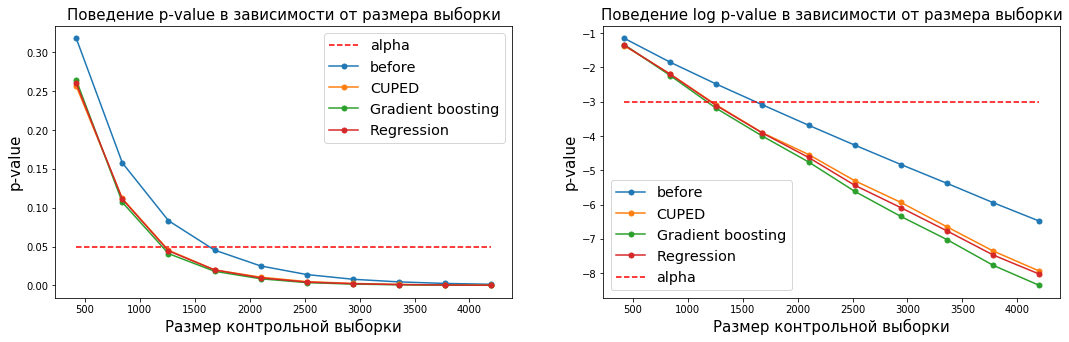

In [134]:
# print(cols_boosting)
draw_graphics(before, after_cup, after_gb, after_dr, title=f'Маленькие фолды: {control_indexes_small[0].shape[0]}\nМаленькая история: {control_sample_hist.shape[0]}')
plt.show()

## Множественная регрессия

In [64]:
def modify_with_regression_test(control, experimental, control_hist, experimental_hist, columns):

    print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")

    Z = pd.concat((control, experimental, control_hist, experimental_hist), axis=0).sample(frac=1)
    means = np.mean(Z[columns])

    Y = Z['visit']
    X = Z[columns]
    X = X - means.values
    X = pd.concat((X, Z['treatment']), axis=1)

    table_summary, model = get_coef_significance(sm.tools.tools.add_constant(X), Y)
#     print(table_summary)
    p_after = table_summary.iloc[-1, :]['P>|t|']
    
    return p_after

## CUPED

In [23]:
def modify_with_cuped(control, experimental, control_hist, experimental_hist, columns, pipeline=False, encoder="OHE", verbose=False):

    print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")

    X = pd.concat((control_hist, experimental_hist), axis=0).sample(frac=1)
    
    Y = X['visit']
    X = X[columns]
    
    categorical_columns = list(set(cat_features).intersection(set(columns)))
    numerical_columns = list(set(noncat_features).intersection(set(columns)))
    

#     table_summary, model = get_coef_significance(sm.tools.tools.add_constant(X), Y)
#     print(table_summary)
#     theta = table_summary['coef'][1:]


    if pipeline:
        means = np.mean(X[numerical_columns])
        X[numerical_columns] = X[numerical_columns] - means
        
        if encoder == 'OHE':
            categorical_encoder = OneHotEncoder(
            handle_unknown="ignore"
            )
        else:  
            categorical_encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1
            )
            
        numerical_pipe = SimpleImputer(strategy="mean")

        preprocessing = ColumnTransformer(
            [
                ("cat", categorical_encoder, categorical_columns),
                ("num", numerical_pipe, numerical_columns),
            ],
            verbose_feature_names_out=False,
        )

        reg = Pipeline(
            [
                ("preprocess", preprocessing),
                ("regressor", linear_model.LinearRegression()),
            ]
        )
        reg.fit(X, Y)
        c = control[columns]
        e = experimental[columns]
        c[numerical_columns] = c[numerical_columns] - means
        e[numerical_columns] = e[numerical_columns] - means
    else:
        means = np.mean(X)
        X = X - means
        
        reg = Pipeline(
            [
                ("regressor", linear_model.LinearRegression()),
            ]
        )
        reg.fit(X, Y)
    
        c = control[columns] - means
        e = experimental[columns] - means

    

    y_c = control['visit']
    y_e = experimental['visit']


    control_cuped = y_c - reg.predict(c) + reg.predict(c).mean()
    experimental_cuped = y_e - reg.predict(e) + reg.predict(e).mean()
    
    if verbose:
        print(f"control var new: {np.var(control_cuped)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cuped)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cuped.mean() - experimental_cuped.mean()}")
    
    
    print("БЫЛО:")
    p_before = ttest(y_c, y_e)
    
    print("Стало:")
    p_after = ttest(control_cuped, experimental_cuped)
    print('\n')
    return p_before, p_after

## Бустинг

In [56]:
def modify_with_gb(control, experimental, control_hist, experimental_hist, columns, pipeline=False, encoder='OHE', verbose=False):
    
    print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")

    X = pd.concat((control_hist, experimental_hist), axis=0).sample(frac=1)


    Y = X['visit']
    X = X[columns]
    
    categorical_columns = list(set(cat_features).intersection(set(columns)))
    numerical_columns = list(set(noncat_features).intersection(set(columns)))
    
    if pipeline:
        means = np.mean(X[numerical_columns])
        X[numerical_columns] = X[numerical_columns] - means
        
        if encoder == 'OHE':
            categorical_encoder = OneHotEncoder(
            handle_unknown="ignore"
            )
        else:  
            categorical_encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1
            )
            
        numerical_pipe = SimpleImputer(strategy="mean")

        preprocessing = ColumnTransformer(
            [
                ("cat", categorical_encoder, categorical_columns),
                ("num", numerical_pipe, numerical_columns),
            ],
            verbose_feature_names_out=False,
        )

        reg = Pipeline(
            [
                ("preprocess", preprocessing),
                ("regressor", GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, min_samples_split=2, min_samples_leaf=1, max_depth=3, random_state=2)),
            ]
        )
        reg.fit(X, Y)
        
        c = control[columns]
        e = experimental[columns]
        c[numerical_columns] = c[numerical_columns] - means
        e[numerical_columns] = e[numerical_columns] - means
    else:
        means = np.mean(X)
        X = X - means
        
        reg = Pipeline(
            [
                ("regressor", GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, min_samples_split=2, min_samples_leaf=1, max_depth=3, random_state=2).fit(X, Y)),
            ]
        )
        reg.fit(X, Y)
    
        c = control[columns] - means
        e = experimental[columns] - means
    


    y_c = control['visit']
    y_e = experimental['visit']

    

    control_cuped = y_c - reg.predict(c)  + reg.predict(c).mean()
    experimental_cuped = y_e - reg.predict(e) + reg.predict(e).mean()
    
    
    
    if verbose:
        print(f"control var new: {np.var(control_cuped)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cuped)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cuped.mean() - experimental_cuped.mean()}")
    
    
    print("БЫЛО:")
    p_before = ttest(y_c, y_e)
    
    print("Стало:")
    p_after = ttest(control_cuped, experimental_cuped)
    print('\n')
    return p_before, p_after

## Минимизация дисперсии

In [44]:
def modify_with_var_min(control, experimental, control_hist, experimental_hist, columns, verbose=False):

    print(f"Control size: {control.shape[0]}, Experimental size: {experimental.shape[0]}")

    X = pd.concat((control_hist, experimental_hist), axis=0).sample(frac=1)
    means = np.mean(X[columns])
    
    Y = X['visit']
    X = X[columns]
    X = X - means.values

    X = X.T.values
    p, n = X.shape


    I = np.eye(n)
    P = 1 / n * np.ones((n,n))
    A = I - P
    
    # считаем theta по всем данным
    b = X @ A @ Y
    B = X @ A @ X.T 

    # Solve Bx = b <=> x = B^-1 b
    theta = np.linalg.inv(X @ A @ X.T) @ X @ A @ Y

#     try:
#         c, low = scipy.linalg.cho_factor(B)
#         theta = scipy.linalg.cho_solve((c, low), b)
#     except:
#         print('computational_error')

    # print(theta)


    y_c = control['visit']
    y_e = experimental['visit']

    c = (control[columns] - means).values
    e = (experimental[columns] - means).values


    control_cuped = y_c - c @ theta
    experimental_cuped = y_e - e @ theta
    
    if verbose:
        print(f"control var new: {np.var(control_cuped)}, var old: {np.var(y_c)}")
        print(f"exper var new: {np.var(experimental_cuped)}, var old: {np.var(y_e)}")

        print(f"Mean diff\nold: {y_c.mean() - y_e.mean()}, new: {control_cuped.mean() - experimental_cuped.mean()}")
    
    
    print("БЫЛО:")
    _ = ttest(y_c, y_e)
    
    print("Стало:")
    _ = ttest(control_cuped, experimental_cuped)
    print('\n')

# Отбор признаков регрессия

## Ordinal Encoding

In [462]:
X = pd.concat((control_sample_hist, treatment_sample_hist, control_indexes_small[0], treatment_indexes_small[0]), axis=0).sample(frac=1)
X.iloc[:, :12]

f0        f1        f2        f3        f4        f5  \
5624559   0.000166  0.000267  0.000269  0.000285  0.000266  0.000272   
12702205  0.000312  0.000267  0.000260  0.000285  0.000266  0.000272   
7784609   0.000323  0.000267  0.000260  0.000285  0.000266  0.000272   
8326404   0.000335  0.000267  0.000260  0.000285  0.000266  0.000272   
2316642   0.000166  0.000267  0.000283  0.000285  0.000266  0.000272   
...            ...       ...       ...       ...       ...       ...   
4962877   0.000322  0.000267  0.000260  0.000285  0.000266  0.000272   
13549456  0.000323  0.000267  0.000260  0.000285  0.000266  0.000272   
5417451   0.000166  0.000267  0.000284  0.000285  0.000266  0.000272   
3627986   0.000316  0.000267  0.000260  0.000285  0.000266  0.000272   
6301477   0.000299  0.000267  0.000260  0.000285  0.000266  0.000272   

                f6        f7        f8        f9       f10       f11  
5624559   0.000013  0.000247  0.000260  0.000500  0.000266 -0.000262  
12702205 -0.000199  0.000247  0.000270  0.000202  0.000266 -0.000262  
7784609  -0.000142  0.000247  0.000270  0.000202  0.000266 -0.000262  
8326404  -0.000056  0.000247  0.000270  0.000202  0.000266 -0.000262  
2316642   0.000013  0.000247  0.000265  0.000202  0.000266 -0.000262  
...            ...       ...       ...       ...       ...       ...  
4962877  -0.000455  0.000247  0.000270  0.000202  0.000266 -0.000262  
13549456 -0.000056  0.000247  0.000270  0.000202  0.000266 -0.000262  
5417451   0.000013  0.000247  0.000266  0.000202  0.000266 -0.000262  
3627986  -0.000290  0.000247  0.000270  0.000202  0.000266 -0.000262  
6301477  -0.000142  0.000247  0.000270  0.000202  0.000266 -0.000262  

[9781 rows x 12 columns]

In [464]:
table_summary, model = get_coef_significance(sm.tools.tools.add_constant(X.iloc[:, :12]), X['visit'])
table_summary

coef   std err       t  P>|t|     [0.025     0.975]
const      5.0581     0.460  11.006  0.000      4.157      5.959
f0       -80.2247    38.572  -2.080  0.038   -155.834     -4.616
f1       400.2075  1031.478   0.388  0.698  -1621.702   2422.117
f2     -3021.5843   287.343 -10.516  0.000  -3584.836  -2458.333
f3        26.3707    33.750   0.781  0.435    -39.785     92.527
f4      1090.2046   409.890   2.660  0.008    286.735   1893.675
f5      -343.7983   149.985  -2.292  0.022   -637.799    -49.797
f6       -63.8241    13.783  -4.631  0.000    -90.842    -36.806
f7       -63.5449    56.545  -1.124  0.261   -174.385     47.296
f8    -16880.0000   983.723 -17.163  0.000 -18800.000 -15000.000
f9       423.7605    33.230  12.753  0.000    358.624    488.897
f10     -511.1785   330.296  -1.548  0.122  -1158.627    136.270
f11     -215.8656    87.269  -2.474  0.013   -386.931    -44.800

In [466]:
# Значимые признаки в регрессии

cols_regr_nocoding = ['f0', 'f2', 'f4', 'f5', 'f6', 'f8', 'f9', 'f11']
cols_regr_nocoding

['f0', 'f2', 'f4', 'f5', 'f6', 'f8', 'f9', 'f11']

## Корреляция

In [473]:
a = np.abs(df.corr().visit).sort_values(ascending=False)
a

visit         1.000000
f9            0.495268
f8            0.457967
exposure      0.308737
f4            0.267452
conversion    0.243565
f11           0.216728
f3            0.207821
f10           0.205816
f5            0.138319
f6            0.137480
f0            0.134034
f1            0.112029
f7            0.091858
f2            0.030331
treatment     0.017451
Name: visit, dtype: float64

In [479]:
# Признаки наиболее коррелирующие с таргетом
cols_regr_corr = ['f9', 'f8', 'f4', 'f11', 'f3', 'f10']

In [ ]:
X = pd.concat((control_sample_hist, treatment_sample_hist, control_indexes_small[0], treatment_indexes_small[0]), axis=0).sample(frac=1)
X.iloc[:, :12]

In [408]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

y = X.visit
categorical_columns = cat_features
numerical_columns = noncat_features

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [410]:
categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1,
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    sparse_threshold=0,
    verbose_feature_names_out=False,
)

In [411]:
X_trans = preprocessing.fit_transform(X_train)

In [415]:
table_summary, model = get_coef_significance(sm.tools.tools.add_constant(X_trans), y_train)
table_summary

coef     std err       t  P>|t|    [0.025       0.975]
const     1.1586    0.153000   7.593  0.000     0.859     1.458000
x1        0.0339    0.015000   2.306  0.021     0.005     0.063000
x2       -0.0006    0.000000  -2.137  0.033    -0.001    -0.000047
x3       -0.0082    0.003000  -3.148  0.002    -0.013    -0.003000
x4        0.0027    0.005000   0.535  0.593    -0.007     0.013000
x5       -0.0004    0.000082  -4.291  0.000    -0.001    -0.000000
x6       -0.0014    0.000063 -22.363  0.000    -0.002    -0.001000
x7        0.0011    0.000000   7.143  0.000     0.001     0.001000
x8       -0.0059    0.008000  -0.779  0.436    -0.021     0.009000
x9     -262.6368   31.995000  -8.209  0.000  -325.353  -199.920000
x10     559.5238  253.975000   2.203  0.028    61.684  1057.363000
x11   -1916.8153  233.087000  -8.224  0.000 -2373.710 -1459.920000
x12      87.2980   39.898000   2.188  0.029     9.090   165.506000

In [45]:
# Значимые признаки после Ordinal Encoding
cols_regr_ordinal = ['f6', 'f8', 'f9', 'f0', 'f2']

# Отбор признаков бустинг

## One Hot Encoding

In [200]:
X = pd.concat((test_control, test_treatment, control_sample, treatment_sample, control_sample_hist, treatment_sample), axis=0)
X.head()

f0        f1       f2        f3        f4        f5        f6  \
620    0.000302  0.000267  0.00026  0.000285  0.000266  0.000272 -0.000056   
11853  0.000261  0.000267  0.00026  0.000140  0.000266  0.000272 -0.000303   
74403  0.000338  0.000267  0.00026  0.000285  0.000266  0.000272 -0.000597   
76353  0.000269  0.000267  0.00026  0.000285  0.000266  0.000272 -0.000056   
93041  0.000341  0.000267  0.00026  0.000285  0.000266  0.000272 -0.000445   

             f7       f8        f9       f10       f11  treatment  conversion  \
620    0.000247  0.00027  0.000202  0.000266 -0.000262          0           0   
11853  0.000247  0.00027  0.000202  0.000266 -0.000262          0           0   
74403  0.000247  0.00027  0.000202  0.000266 -0.000262          0           0   
76353  0.000247  0.00027  0.000202  0.000266 -0.000262          0           0   
93041  0.000247  0.00027  0.000202  0.000266 -0.000262          0           0   

       visit  exposure  
620        0         0  
11853      0         0  
74403      0         0  
76353      0         0  
93041      0         0

In [201]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

y = X.visit
categorical_columns = cat_features
numerical_columns = noncat_features

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [202]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

categorical_encoder = OneHotEncoder(
    handle_unknown="ignore"
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f1', 'f3', 'f4', 'f5', 'f6',
                                                   'f8', 'f9', 'f11']),
                                                 ('num', SimpleImputer(),
                                                  ['f0', 'f10', 'f2', 'f7'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [203]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.999
RF test accuracy: 0.980


In [204]:

import numpy as np  
import pandas as pd  
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
import plotly.express as px


class FeatureImportance:

    """
    
    Extract & Plot the Feature Names & Importance Values from a Scikit-Learn Pipeline.
    
    The input is a Pipeline that starts with a ColumnTransformer & ends with a regression or classification model. 
    As intermediate steps, the Pipeline can have any number or no instances from sklearn.feature_selection.

    Note: 
    If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns, 
    it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns 
    to the dataset that didn't exist before, so there should come last in the Pipeline.
    
    
    Parameters
    ----------
    pipeline : a Scikit-learn Pipeline class where the a ColumnTransformer is the first element and model estimator is the last element
    verbose : a boolean. Whether to print all of the diagnostics. Default is False.
    
    Attributes
    __________
    column_transformer_features :  A list of the feature names created by the ColumnTransformer prior to any selectors being applied
    transformer_list : A list of the transformer names that correspond with the `column_transformer_features` attribute
    discarded_features : A list of the features names that were not selected by a sklearn.feature_selection instance.
    discarding_selectors : A list of the selector names corresponding with the `discarded_features` attribute
    feature_importance :  A Pandas Series containing the feature importance values and feature names as the index.    
    plot_importances_df : A Pandas DataFrame containing the subset of features and values that are actually displaced in the plot. 
    feature_info_df : A Pandas DataFrame that aggregates the other attributes. The index is column_transformer_features. The transformer column contains the transformer_list.
        value contains the feature_importance values. discarding_selector contains discarding_selectors & is_retained is a Boolean indicating whether the feature was retained.
    
    
    
    """
    def __init__(self, pipeline, verbose=False):
        self.pipeline = pipeline
        self.verbose = verbose


    def get_feature_names(self, verbose=None):  

        """

        Get the column names from the a ColumnTransformer containing transformers & pipelines

        Parameters
        ----------
        verbose : a boolean indicating whether to print summaries. 
            default = False


        Returns
        -------
        a list of the correct feature names

        Note: 
        If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns, 
        it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns 
        to the dataset that didn't exist before, so there should come last in the Pipeline.

        Inspiration: https://github.com/scikit-learn/scikit-learn/issues/12525 

        """

        if verbose is None:
            verbose = self.verbose
            
        if verbose: print('''\n\n---------\nRunning get_feature_names\n---------\n''')
        
        column_transformer = self.pipeline[0]        
        assert isinstance(column_transformer, ColumnTransformer), "Input isn't a ColumnTransformer"
        check_is_fitted(column_transformer)

        new_feature_names, transformer_list = [], []

        for i, transformer_item in enumerate(column_transformer.transformers_): 
            
            transformer_name, transformer, orig_feature_names = transformer_item
            orig_feature_names = list(orig_feature_names)
            
            if verbose: 
                print('\n\n', i, '. Transformer/Pipeline: ', transformer_name, ',', 
                      transformer.__class__.__name__, '\n')
                print('\tn_orig_feature_names:', len(orig_feature_names))

            if transformer == 'drop':
                    
                continue
                
            if isinstance(transformer, Pipeline):
                # if pipeline, get the last transformer in the Pipeline
                transformer = transformer.steps[-1][1]

            if hasattr(transformer, 'get_feature_names'):

                if 'input_features' in transformer.get_feature_names.__code__.co_varnames:

                    names = list(transformer.get_feature_names(orig_feature_names))

                else:

                    names = list(transformer.get_feature_names())

            elif hasattr(transformer,'indicator_') and transformer.add_indicator:
                # is this transformer one of the imputers & did it call the MissingIndicator?

                missing_indicator_indices = transformer.indicator_.features_
                missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                      for idx in missing_indicator_indices]
                names = orig_feature_names + missing_indicators

            elif hasattr(transformer,'features_'):
                # is this a MissingIndicator class? 
                missing_indicator_indices = transformer.features_
                missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                      for idx in missing_indicator_indices]

            else:

                names = orig_feature_names

            if verbose: 
                print('\tn_new_features:', len(names))
                print('\tnew_features:\n', names)

            new_feature_names.extend(names)
            transformer_list.extend([transformer_name] * len(names))
        
        self.transformer_list, self.column_transformer_features = transformer_list,\
                                                                    new_feature_names

        return new_feature_names

    
    def get_selected_features(self, verbose=None):
        """

        Get the Feature Names that were retained after Feature Selection (sklearn.feature_selection)

        Parameters
        ----------
        verbose : a boolean indicating whether to print summaries. default = False

        Returns
        -------
        a list of the selected feature names


        """

        if verbose is None:
            verbose = self.verbose

        assert isinstance(self.pipeline, Pipeline), "Input isn't a Pipeline"

        features = self.get_feature_names()
        
        if verbose: print('\n\n---------\nRunning get_selected_features\n---------\n')
            
        all_discarded_features, discarding_selectors = [], []

        for i, step_item in enumerate(self.pipeline.steps[:]):
            
            step_name, step = step_item

            if hasattr(step, 'get_support'):

                if verbose: print('\nStep ', i, ": ", step_name, ',', 
                                  step.__class__.__name__, '\n')
                    
                check_is_fitted(step)

                feature_mask_dict = dict(zip(features, step.get_support()))
                
                features = [feature for feature, is_retained in feature_mask_dict.items()\
                            if is_retained]
                                         
                discarded_features = [feature for feature, is_retained in feature_mask_dict.items()\
                                      if not is_retained]
                
                all_discarded_features.extend(discarded_features)
                discarding_selectors.extend([step_name] * len(discarded_features))
                
                
                if verbose: 
                    print(f'\t{len(features)} retained, {len(discarded_features)} discarded')
                    if len(discarded_features) > 0:
                        print('\n\tdiscarded_features:\n\n', discarded_features)

        self.discarded_features, self.discarding_selectors = all_discarded_features,\
                                                                discarding_selectors
        
        return features

    def get_feature_importance(self):
        
        """
        Creates a Pandas Series where values are the feature importance values from the model and feature names are set as the index. 
        
        This Series is stored in the `feature_importance` attribute.

        Returns
        -------
        A pandas Series containing the feature importance values and feature names as the index.
        
        """
        
        assert isinstance(self.pipeline, Pipeline), "Input isn't a Pipeline"

        features = self.get_selected_features()
             
        assert hasattr(self.pipeline[-1], 'feature_importances_'),\
            "The last element in the pipeline isn't an estimator with a feature_importances_ attribute"
        
        importance_values = self.pipeline[-1].feature_importances_
        
        assert len(features) == len(importance_values),\
            "The number of feature names & importance values doesn't match"
        
        feature_importance = pd.Series(importance_values, index=features)
        self.feature_importance = feature_importance
        
        # create feature_info_df
        column_transformer_df =\
            pd.DataFrame(dict(transformer=self.transformer_list),
                         index=self.column_transformer_features)

        discarded_features_df =\
            pd.DataFrame(dict(discarding_selector=self.discarding_selectors),
                         index=self.discarded_features)

        importance_df = self.feature_importance.rename('value').to_frame()

        self.feature_info_df = \
            column_transformer_df\
            .join([importance_df, discarded_features_df])\
            .assign(is_retained = lambda df: ~df.value.isna())        


        return feature_importance
        
    
    def plot(self, top_n_features=100, rank_features=True, max_scale=True, 
             display_imp_values=True, display_imp_value_decimals=1,
             height_per_feature=25, orientation='h', width=750, height=None, 
             str_pad_width=15, yaxes_tickfont_family='Courier New', 
             yaxes_tickfont_size=15):
        """

        Plot the Feature Names & Importances 


        Parameters
        ----------

        top_n_features : the number of features to plot, default is 100
        rank_features : whether to rank the features with integers, default is True
        max_scale : Should the importance values be scaled by the maximum value & mulitplied by 100?  Default is True.
        display_imp_values : Should the importance values be displayed? Default is True.
        display_imp_value_decimals : If display_imp_values is True, how many decimal places should be displayed. Default is 1.
        height_per_feature : if height is None, the plot height is calculated by top_n_features * height_per_feature. 
        This allows all the features enough space to be displayed
        orientation : the plot orientation, 'h' (default) or 'v'
        width :  the width of the plot, default is 500
        height : the height of the plot, the default is top_n_features * height_per_feature
        str_pad_width : When rank_features=True, this number of spaces to add between the rank integer and feature name. 
            This will enable the rank integers to line up with each other for easier reading. 
            Default is 15. If you have long feature names, you can increase this number to make the integers line up more.
            It can also be set to 0.
        yaxes_tickfont_family : the font for the feature names. Default is Courier New.
        yaxes_tickfont_size : the font size for the feature names. Default is 15.

        Returns
        -------
        plot

        """
        if height is None:
            height = top_n_features * height_per_feature
            
        # prep the data
        
        all_importances = self.get_feature_importance()

        n_all_importances = len(all_importances)
        
        plot_importances_df =\
            all_importances\
            .nlargest(top_n_features)\
            .sort_values()\
            .to_frame('value')\
            .rename_axis('feature')\
            .reset_index()
                
        if max_scale:
            plot_importances_df['value'] = \
                                plot_importances_df.value.abs() /\
                                plot_importances_df.value.abs().max() * 100
            
        self.plot_importances_df = plot_importances_df.copy()
        
        if len(all_importances) < top_n_features:
            title_text = 'All Feature Importances'
        else:
            title_text = f'Top {top_n_features} (of {n_all_importances}) Feature Importances'       
        
        if rank_features:
            padded_features = \
                plot_importances_df.feature\
                .str.pad(width=str_pad_width)\
                .values
            
            ranked_features =\
                plot_importances_df.index\
                .to_series()\
                .sort_values(ascending=False)\
                .add(1)\
                .astype(str)\
                .str.cat(padded_features, sep='. ')\
                .values

            plot_importances_df['feature'] = ranked_features
        
        if display_imp_values:
            text = plot_importances_df.value.round(display_imp_value_decimals)
        else:
            text = None

        # create the plot 
  
        fig = px.bar(plot_importances_df, 
                     x='value', 
                     y='feature',
                     orientation=orientation, 
                     width=width, 
                     height=height,
                     text=text)
        fig.update_layout(title_text=title_text, title_x=0.5) 
        fig.update(layout_showlegend=False)
        fig.update_yaxes(tickfont=dict(family=yaxes_tickfont_family, 
                                       size=yaxes_tickfont_size),
                         title='')
        fig.show()

In [205]:
feature_importance = FeatureImportance(rf)
feature_importance.plot(top_n_features=20)

# x6 -> 6ая фича в массиве X.columns

In [26]:
cols_boosting = ['f2', 'f0', 'f9', 'f10', 'f4', 'f7', 'f8']#, 'f3', 'f11']

## Ordinal Encoding

In [211]:
X = pd.concat((test_control, test_treatment, control_sample, treatment_sample, control_sample_hist, treatment_sample), axis=0)
X.head()

f0        f1       f2        f3        f4        f5        f6  \
620    0.000302  0.000267  0.00026  0.000285  0.000266  0.000272 -0.000056   
11853  0.000261  0.000267  0.00026  0.000140  0.000266  0.000272 -0.000303   
74403  0.000338  0.000267  0.00026  0.000285  0.000266  0.000272 -0.000597   
76353  0.000269  0.000267  0.00026  0.000285  0.000266  0.000272 -0.000056   
93041  0.000341  0.000267  0.00026  0.000285  0.000266  0.000272 -0.000445   

             f7       f8        f9       f10       f11  treatment  conversion  \
620    0.000247  0.00027  0.000202  0.000266 -0.000262          0           0   
11853  0.000247  0.00027  0.000202  0.000266 -0.000262          0           0   
74403  0.000247  0.00027  0.000202  0.000266 -0.000262          0           0   
76353  0.000247  0.00027  0.000202  0.000266 -0.000262          0           0   
93041  0.000247  0.00027  0.000202  0.000266 -0.000262          0           0   

       visit  exposure  
620        0         0  
11853      0         0  
74403      0         0  
76353      0         0  
93041      0         0

In [212]:
y = X.visit
categorical_columns = cat_features
numerical_columns = noncat_features

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [213]:
OrdinalEncoder = OneHotEncoder(
    handle_unknown="ignore"
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.999
RF test accuracy: 0.980


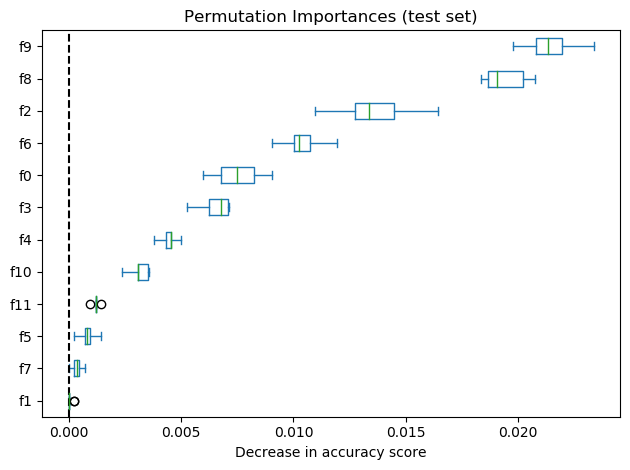

In [214]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [40]:
# the most influencing features with Ordinal Encoding

cols_boosting_ord = ['f9', 'f8', 'f2', 'f6', 'f3', 'f0']

In [388]:
quant = np.quantile(mdi_importances.values, 0.5)
quant

0.05243007889387984

In [389]:
mdi_importances[mdi_importances >= quant].index

Index(['f8', 'f9', 'f2', 'f0', 'f6', 'f3'], dtype='object')

# Тестирование 

In [94]:
def draw_graphics(before=None, after_cup=None, after_gb=None, p_after_reg=None, title='', alpha=0.05):
    if len(title) != 0:
        print('\n', title, '\n')
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    ax1.plot(shapes, [alpha] * len(shapes), color="red", linestyle='dashed', label='alpha')
    if not (before is None):
        ax1.plot(shapes, before, marker='o', ms=5, label='before')
        ax2.plot(shapes, np.log(before), marker='o', ms=5, label='before')
    if not (after_cup is None):
        ax1.plot(shapes, after_cup, marker='o', ms=5, label='CUPED')
        ax2.plot(shapes, np.log(after_cup), marker='o', ms=5, label='CUPED')
    if not (after_gb is None):
        ax1.plot(shapes, after_gb, marker='o', ms=5, label='Gradient boosting')
        ax2.plot(shapes, np.log(after_gb), marker='o', ms=5, label='Gradient boosting')
    if not (p_after_reg is None):
        ax1.plot(shapes, p_after_reg, marker='o', ms=5, label='Regression')
        ax2.plot(shapes, np.log(p_after_reg), marker='o', ms=5, label='Regression')
    ax1.set_xlabel('Размер контрольной выборки', fontsize=15)
    ax1.set_ylabel('p-value', fontsize=15)
    ax1.set_title(f'Поведение p-value в зависимости от размера выборки', fontsize=15)

    ax2.plot(shapes, [np.log(alpha)] * len(shapes), color="red", linestyle='dashed', label='alpha')
    ax2.set_xlabel('Размер контрольной выборки', fontsize=15)
    ax2.set_ylabel('p-value', fontsize=15)
    ax2.set_title(f'Поведение log p-value в зависимости от размера выборки',fontsize=15)

    ax1.legend(fontsize='x-large')
    ax2.legend(fontsize='x-large')

### Маленький исторический контекст

In [101]:
# size= 0.0002

indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal#['f2', 'f11', 'f10']#['f4', 'f11']
cols2 = cols_boosting#['f2', 'f11', 'f10']
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []
after_dr = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_small))):
    test_control = control_indexes_small[i]
    test_treatment = treatment_indexes_small[i]
    
    print(f'control repeated: {np.isin(test_control.index, indexes_control).sum()}, treatment repeated: {np.isin(test_treatment.index, indexes_treatment).sum()}')
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]

    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols1, True, encoder="Ord", verbose=True)
    
    p_bef, p_aft_gb = modify_with_gb(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols2, False, verbose=True)
    p_aft_reg = modify_with_regression_test(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols3)
    p_aft_dr = doubly_robust(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols2)
    
    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)
    after_dr.append(p_aft_dr)

CUPED with small history




  0%|          | 0/10 [00:00<?, ?it/s]

control repeated: 0, treatment repeated: 0
Control size: 420, Experimental size: 2375
control var new: 0.028541942032216192, var old: 0.03664399092970536
exper var new: 0.03466447844016516, var old: 0.04607645429362977
Mean diff
old: -0.01032581453634085, new: -0.010325814536340995
БЫЛО:
p-val: 0.31824899355404984
Статзначимой разницы нет
Стало:
p-val: 0.2566868092665644
Статзначимой разницы нет


Control size: 420, Experimental size: 2375


 10%|█         | 1/10 [00:01<00:12,  1.34s/it]

control var new: 0.030155552546241606, var old: 0.03664399092970536
exper var new: 0.03197350333951455, var old: 0.04607645429362977
Mean diff
old: -0.01032581453634085, new: -0.010325814536341446
БЫЛО:
p-val: 0.31824899355404984
Статзначимой разницы нет
Стало:
p-val: 0.26440267089969594
Статзначимой разницы нет


Control size: 420, Experimental size: 2375
Control size: 420, Experimental size: 2375
p-val: 0.2571213531409236
Статзначимой разницы нет
control repeated: 0, treatment repeated: 0
Control size: 840, Experimental size: 4750
control var new: 0.029361071973536233, var old: 0.036643990929705696
exper var new: 0.03392494924526918, var old: 0.04607645429362834
Mean diff
old: -0.01032581453634085, new: -0.010325814536340787
БЫЛО:
p-val: 0.15781016139054183
Статзначимой разницы нет
Стало:
p-val: 0.1119434933609555
Статзначимой разницы нет


Control size: 840, Experimental size: 4750


 20%|██        | 2/10 [00:02<00:11,  1.38s/it]

control var new: 0.028795357035169746, var old: 0.036643990929705696
exper var new: 0.031646253256557684, var old: 0.04607645429362834
Mean diff
old: -0.01032581453634085, new: -0.010325814536342355
БЫЛО:
p-val: 0.15781016139054183
Статзначимой разницы нет
Стало:
p-val: 0.10702736795177062
Статзначимой разницы нет


Control size: 840, Experimental size: 4750
Control size: 840, Experimental size: 4750
p-val: 0.2607123720023944
Статзначимой разницы нет
control repeated: 0, treatment repeated: 1
Control size: 1260, Experimental size: 7124
control var new: 0.02757866694646116, var old: 0.03664399092970581
exper var new: 0.0335119070945788, var old: 0.046082592913342525
Mean diff
old: -0.010332611427501935, new: -0.010332611427501921
БЫЛО:
p-val: 0.08337598566194428
Статзначимой разницы нет
Стало:
p-val: 0.045320027064992
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1260, Experimental size: 7124


 30%|███       | 3/10 [00:04<00:09,  1.34s/it]

control var new: 0.026538925573462175, var old: 0.03664399092970581
exper var new: 0.03170393225099749, var old: 0.046082592913342525
Mean diff
old: -0.010332611427501935, new: -0.010332611427504988
БЫЛО:
p-val: 0.08337598566194428
Статзначимой разницы нет
Стало:
p-val: 0.0410026122225977
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1260, Experimental size: 7124
Control size: 1260, Experimental size: 7124
p-val: 0.28561397187045584
Статзначимой разницы нет
control repeated: 0, treatment repeated: 1
Control size: 1680, Experimental size: 9498
control var new: 0.027135899615360816, var old: 0.03664399092970586
exper var new: 0.034089956667575146, var old: 0.04608566283484745
Mean diff
old: -0.010336010588695363, new: -0.010336010588695363
БЫЛО:
p-val: 0.04548452741295379
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.02011482987380594
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)




 40%|████      | 4/10 [00:05<00:08,  1.38s/it]

control var new: 0.026479004896499365, var old: 0.03664399092970586
exper var new: 0.03203244952774391, var old: 0.04608566283484745
Mean diff
old: -0.010336010588695363, new: -0.010336010588691477
БЫЛО:
p-val: 0.04548452741295379
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.018237959188296175
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1680, Experimental size: 9498
Control size: 1680, Experimental size: 9498
p-val: 0.39879380150991983
Статзначимой разницы нет
control repeated: 0, treatment repeated: 5
Control size: 2100, Experimental size: 11868
control var new: 0.028424458895142227, var old: 0.0366439909297059
exper var new: 0.03419968076053927, var old: 0.04610224746109099
Mean diff
old: -0.01035437430786268, new: -0.010354374307862783
БЫЛО:
p-val: 0.02507735027833645
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.010667459050229915
Стат. значимая разница (отв

 50%|█████     | 5/10 [00:06<00:07,  1.41s/it]

control var new: 0.026912767835328116, var old: 0.0366439909297059
exper var new: 0.03180726369580523, var old: 0.04610224746109099
Mean diff
old: -0.01035437430786268, new: -0.010354374307861548
БЫЛО:
p-val: 0.02507735027833645
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.008585446065735162
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2100, Experimental size: 11868
Control size: 2100, Experimental size: 11868
p-val: 0.39365629384372647
Статзначимой разницы нет
control repeated: 0, treatment repeated: 4
Control size: 2520, Experimental size: 14239
control var new: 0.02816861668968441, var old: 0.03664399092970592
exper var new: 0.034317184199536624, var old: 0.046110236897161844
Mean diff
old: -0.010363221066219869, new: -0.010363221066219876
БЫЛО:
p-val: 0.014043153933571856
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.004966732813556203
Стат. значимая разница 

 60%|██████    | 6/10 [00:08<00:05,  1.39s/it]

control var new: 0.026303912205102885, var old: 0.03664399092970592
exper var new: 0.0319487232906863, var old: 0.046110236897161844
Mean diff
old: -0.010363221066219869, new: -0.010363221066217024
БЫЛО:
p-val: 0.014043153933571856
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0036407793928086127
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2520, Experimental size: 14239
Control size: 2520, Experimental size: 14239
p-val: 0.36461690026729676
Статзначимой разницы нет
control repeated: 0, treatment repeated: 2
Control size: 2940, Experimental size: 16612
control var new: 0.028807588552741546, var old: 0.03664399092970594
exper var new: 0.034209108885109085, var old: 0.04611067595719794
Mean diff
old: -0.010363707245479456, new: -0.010363707245479574
БЫЛО:
p-val: 0.007974147439119627
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0026347411931261465
Стат. значимая раз

 70%|███████   | 7/10 [00:09<00:04,  1.38s/it]

control var new: 0.026504797617812763, var old: 0.03664399092970594
exper var new: 0.032125898217921264, var old: 0.04611067595719794
Mean diff
old: -0.010363707245479456, new: -0.010363707245475279
БЫЛО:
p-val: 0.007974147439119627
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0017504176299657848
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2940, Experimental size: 16612
Control size: 2940, Experimental size: 16612
p-val: 0.4146617014649485
Статзначимой разницы нет
control repeated: 1, treatment repeated: 3
Control size: 3359, Experimental size: 18984
control var new: 0.028667731289534773, var old: 0.036654467950164325
exper var new: 0.03436645713782485, var old: 0.04611331049245432
Mean diff
old: -0.010355283282065642, new: -0.010355283282065912
БЫЛО:
p-val: 0.004605408373666528
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0012940218181360175
Стат. значимая раз

 80%|████████  | 8/10 [00:11<00:02,  1.38s/it]

control var new: 0.026849013696299592, var old: 0.036654467950164325
exper var new: 0.032366338362340624, var old: 0.04611331049245432
Mean diff
old: -0.010355283282065642, new: -0.010355283282069229
БЫЛО:
p-val: 0.004605408373666528
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0008913630176564377
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 3359, Experimental size: 18984
Control size: 3359, Experimental size: 18984
p-val: 0.30588417141765584
Статзначимой разницы нет
control repeated: 0, treatment repeated: 7
Control size: 3779, Experimental size: 21352
control var new: 0.028713843548516926, var old: 0.036653303541439836
exper var new: 0.03436277630610798, var old: 0.04612355876153575
Mean diff
old: -0.010367892073001886, new: -0.01036789207300206
БЫЛО:
p-val: 0.002621460978584897
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0006391602672711143
Стат. значимая ра

 90%|█████████ | 9/10 [00:12<00:01,  1.38s/it]

control var new: 0.02688529085347616, var old: 0.036653303541439836
exper var new: 0.032365131363029, var old: 0.04612355876153575
Mean diff
old: -0.010367892073001886, new: -0.010367892073015153
БЫЛО:
p-val: 0.002621460978584897
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0004207966866686239
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 3779, Experimental size: 21352
Control size: 3779, Experimental size: 21352
p-val: 0.26751843633182004
Статзначимой разницы нет
control repeated: 1, treatment repeated: 2
Control size: 4198, Experimental size: 23725
control var new: 0.02922927692731337, var old: 0.036660757033736065
exper var new: 0.03424418559015241, var old: 0.046122533730252664
Mean diff
old: -0.010358688542037427, new: -0.010358688542037232
БЫЛО:
p-val: 0.0015326410308989695
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.00035641808326447187
Стат. значимая раз

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

control var new: 0.02753715029521775, var old: 0.036660757033736065
exper var new: 0.03226398687882357, var old: 0.046122533730252664
Mean diff
old: -0.010358688542037427, new: -0.010358688542041472
БЫЛО:
p-val: 0.0015326410308989695
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0002347599988818562
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 4198, Experimental size: 23725
Control size: 4198, Experimental size: 23725
p-val: 0.20303884595088043
Статзначимой разницы нет



 Маленькие фолды: 420
Маленькая история: 1048 



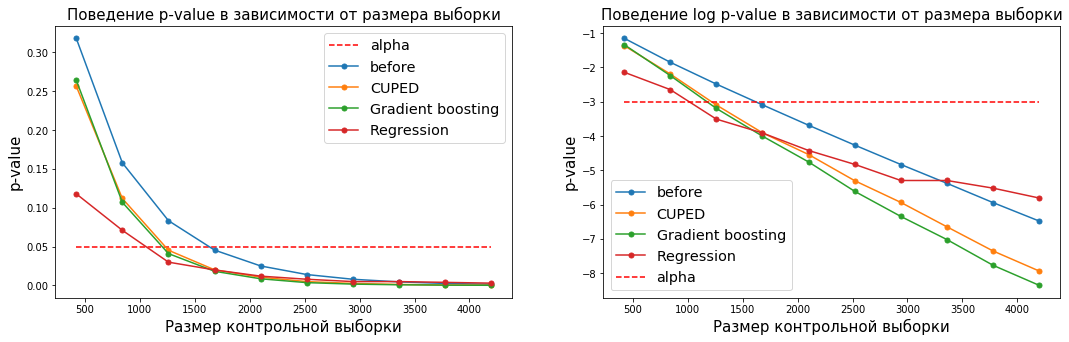

In [96]:
# print(cols_boosting)
draw_graphics(before, after_cup, after_gb, after_reg, title=f'Маленькие фолды: {control_indexes_small[0].shape[0]}\nМаленькая история: {control_sample_hist.shape[0]}')
plt.show()

In [61]:
# size= 0.0002

indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal#['f2', 'f11', 'f10']#['f4', 'f11']
cols2 = cols_boosting#['f2', 'f11', 'f10']
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_small))):
    test_control = control_indexes_small[i]
    test_treatment = treatment_indexes_small[i]
    
    print(f'control repeated: {np.isin(test_control.index, indexes_control).sum()}, treatment repeated: {np.isin(test_treatment.index, indexes_treatment).sum()}')
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]

    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols1, True, encoder="Ord", verbose=True)

    p_bef, p_aft_gb = modify_with_gb(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols2, False, verbose=True)
    p_aft_reg = modify_with_regression_test(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols3)
    
    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)

CUPED with small history




  0%|          | 0/10 [00:00<?, ?it/s]

control repeated: 0, treatment repeated: 0
Control size: 420, Experimental size: 2375
control var new: 0.02854194203221618, var old: 0.03664399092970536
exper var new: 0.03466447844016514, var old: 0.04607645429362977
Mean diff
old: -0.01032581453634085, new: -0.010325814536340891
БЫЛО:
p-val: 0.31824899355404984
Статзначимой разницы нет
Стало:
p-val: 0.256686809266563
Статзначимой разницы нет


Control size: 420, Experimental size: 2375
control var new: 0.030155552546241606, var old: 0.03664399092970536
exper var new: 0.03197350333951455, var old: 0.04607645429362977
Mean diff
old: -0.01032581453634085, new: -0.010325814536341446
БЫЛО:
p-val: 0.31824899355404984
Статзначимой разницы нет
Стало:
p-val: 0.26440267089969594
Статзначимой разницы нет


Control size: 420, Experimental size: 2375
control repeated: 0, treatment repeated: 0
Control size: 840, Experimental size: 4750
control var new: 0.029361071973536244, var old: 0.036643990929705696
exper var new: 0.03392494924526917, var old:

control var new: 0.027537150295217753, var old: 0.036660757033736065
exper var new: 0.03226398687882357, var old: 0.046122533730252664
Mean diff
old: -0.010358688542037427, new: -0.010358688542041472
БЫЛО:
p-val: 0.0015326410308989695
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.0002347599988818562
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 4198, Experimental size: 23725



 Маленькие фолды: 420
Маленькая история: 1048 



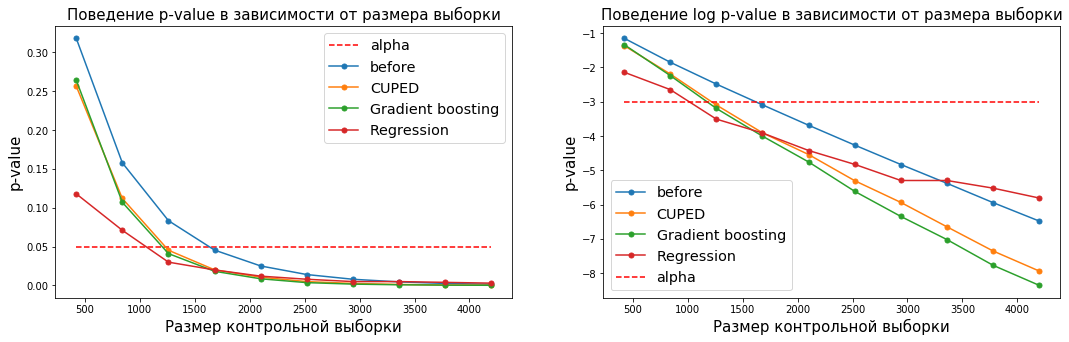

In [62]:
# print(cols_boosting)
draw_graphics(before, after_cup, after_gb, after_reg, title=f'Маленькие фолды: {control_indexes_small[0].shape[0]}\nМаленькая история: {control_sample_hist.shape[0]}')
plt.show()

In [77]:
# size= 0.00035

print(f"CUPED with small history\n\n")
indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal#['f2', 'f11', 'f10']#['f4', 'f11']
cols2 = cols_boosting#['f2', 'f8', 'f9']
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_big))):
    test_control = control_indexes_big[i]
    test_treatment = treatment_indexes_big[i]
    
    print(f'control repeated: {np.isin(test_control.index, indexes_control).sum()}, treatment repeated: {np.isin(test_treatment.index, indexes_treatment).sum()}')
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]

    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols1, True, encoder='Ord')
    _, p_aft_gb = modify_with_gb(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols2)
    p_aft_reg = modify_with_regression_test(all_test_control, all_test_treatment, control_sample_hist, treatment_sample_hist, cols3)

    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)

CUPED with small history




  0%|          | 0/10 [00:00<?, ?it/s]

control repeated: 0, treatment repeated: 0
Control size: 734, Experimental size: 4157
БЫЛО:
p-val: 0.1820126244857117
Статзначимой разницы нет
Стало:
p-val: 0.13249779755687263
Статзначимой разницы нет


Control size: 734, Experimental size: 4157
БЫЛО:
p-val: 0.1820126244857117
Статзначимой разницы нет
Стало:
p-val: 0.12109957142217186
Статзначимой разницы нет


Control size: 734, Experimental size: 4157
control repeated: 0, treatment repeated: 0
Control size: 1468, Experimental size: 8314
БЫЛО:
p-val: 0.05900562667485316
Статзначимой разницы нет
Стало:
p-val: 0.03448242931434411
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1468, Experimental size: 8314
БЫЛО:
p-val: 0.05900562667485316
Статзначимой разницы нет
Стало:
p-val: 0.02631428054013389
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1468, Experimental size: 8314
control repeated: 0, treatment repeated: 3
Control size: 2202, Experimental size: 12468


 Большие фолды: 734
Маленькая история: 1048 



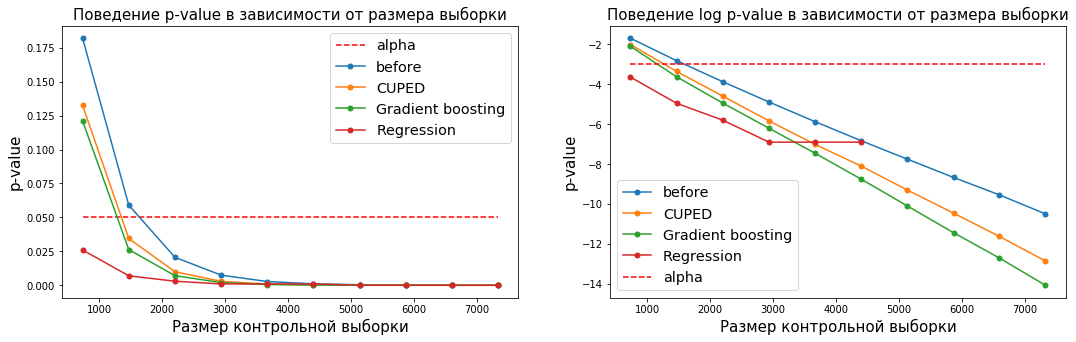

In [78]:
draw_graphics(before, after_cup, after_gb, after_reg, title=f'Большие фолды: {control_indexes_big[0].shape[0]}\nМаленькая история: {control_sample_hist.shape[0]}')
plt.show()

### Большой исторический контекст

In [188]:
# size= 0.0002

indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal#['f2', 'f11', 'f10']#['f4', 'f11']
cols2 = cols_boosting#['f2', 'f8', 'f9']
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_small))):
    test_control = control_indexes_small[i]
    test_treatment = treatment_indexes_small[i]
    
    print(f'control repeated: {np.isin(test_control.index, indexes_control).sum()}, treatment repeated: {np.isin(test_treatment.index, indexes_treatment).sum()}')
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]

    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, control_sample_big_hist, treatment_sample_big_hist, cols1, True, encoder='Ord')
    p_bef, p_aft_gb = modify_with_gb(all_test_control, all_test_treatment, control_sample_big_hist, treatment_sample_big_hist, cols2, False)
    p_aft_reg = modify_with_regression_test(all_test_control, all_test_treatment, control_sample_big_hist, treatment_sample_big_hist, cols3)
    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)

  0%|          | 0/10 [00:00<?, ?it/s]

control repeated: 0, treatment repeated: 0
Control size: 420, Experimental size: 2375
БЫЛО:
p-val: 0.31824899355404984
Статзначимой разницы нет
Стало:
p-val: 0.2609885876625619
Статзначимой разницы нет


Control size: 420, Experimental size: 2375
БЫЛО:
p-val: 0.31824899355404984
Статзначимой разницы нет
Стало:
p-val: 0.2656854368680019
Статзначимой разницы нет


Control size: 420, Experimental size: 2375
0.45 

control repeated: 0, treatment repeated: 0
Control size: 840, Experimental size: 4750
БЫЛО:
p-val: 0.15781016139054183
Статзначимой разницы нет
Стало:
p-val: 0.11229688829267816
Статзначимой разницы нет


Control size: 840, Experimental size: 4750
БЫЛО:
p-val: 0.15781016139054183
Статзначимой разницы нет
Стало:
p-val: 0.10877541676110777
Статзначимой разницы нет


Control size: 840, Experimental size: 4750
0.243 

control repeated: 0, treatment repeated: 1
Control size: 1260, Experimental size: 7124
БЫЛО:
p-val: 0.08337598566194428
Статзначимой разницы нет
Стало:
p-val: 0.044501


 Маленькие фолды: 420
Большая история: 2085 



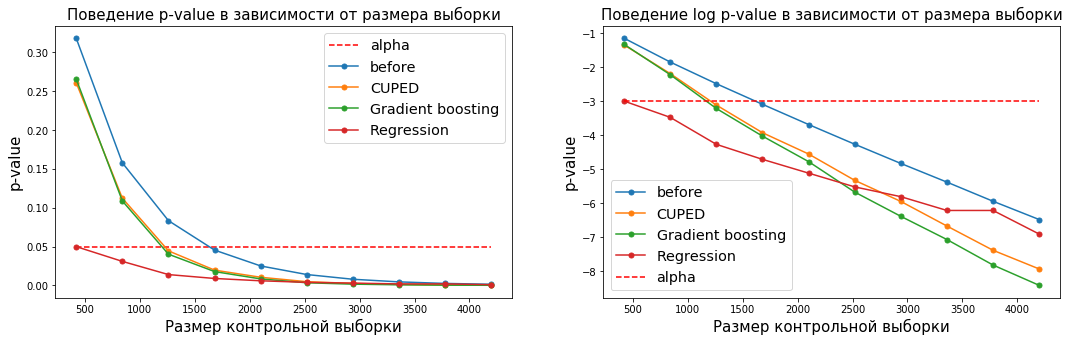

In [80]:
draw_graphics(before, after_cup, after_gb, after_reg, title=f'Маленькие фолды: {control_indexes_small[0].shape[0]}\nБольшая история: {control_sample_big_hist.shape[0]}')
plt.show()

In [81]:
# size= 0.00035

print(f"CUPED with small history\n\n")
indexes_control = np.array([])
indexes_treatment = np.array([])
cols1 = cols_regr_ordinal#['f2', 'f11', 'f10']#['f4', 'f11']
cols2 = cols_boosting#['f2', 'f8', 'f9']
cols3 = ['f4', 'f11', 'f2']

shapes = []

before = []
after_cup = []
after_gb = []
after_reg = []

all_test_control = pd.DataFrame()
all_test_treatment = pd.DataFrame()

i = 0
for i in tqdm(range(0, len(control_indexes_big))):
    test_control = control_indexes_big[i]
    test_treatment = treatment_indexes_big[i]
    
    print(f'control repeated: {np.isin(test_control.index, indexes_control).sum()}, treatment repeated: {np.isin(test_treatment.index, indexes_treatment).sum()}')
    
    test_control = test_control[~np.isin(test_control.index, indexes_control)]
    test_treatment = test_treatment[~np.isin(test_treatment.index, indexes_treatment)]

    all_test_control = pd.concat((all_test_control, test_control), axis=0)
    all_test_treatment = pd.concat((all_test_treatment, test_treatment), axis=0)
    shapes.append(all_test_control.shape[0])
    
    indexes_control = np.append(indexes_control,  test_control.index)
    indexes_treatment = np.append(indexes_treatment,  test_treatment.index)
    
    
    p_bef, p_aft_cup = modify_with_cuped(all_test_control, all_test_treatment, control_sample_big_hist, treatment_sample_big_hist, cols1, True, encoder='Ord')
    p_bef, p_aft_gb = modify_with_gb(all_test_control, all_test_treatment, control_sample_big_hist, treatment_sample_big_hist, cols2, False)
    p_aft_reg = modify_with_regression_test(all_test_control, all_test_treatment, control_sample_big_hist, treatment_sample_big_hist, cols3)
    
    before.append(p_bef)
    after_cup.append(p_aft_cup)
    after_gb.append(p_aft_gb)
    after_reg.append(p_aft_reg)

CUPED with small history




  0%|          | 0/10 [00:00<?, ?it/s]

control repeated: 0, treatment repeated: 0
Control size: 734, Experimental size: 4157
БЫЛО:
p-val: 0.1820126244857117
Статзначимой разницы нет
Стало:
p-val: 0.1304276057948727
Статзначимой разницы нет


Control size: 734, Experimental size: 4157
БЫЛО:
p-val: 0.1820126244857117
Статзначимой разницы нет
Стало:
p-val: 0.11761773004901897
Статзначимой разницы нет


Control size: 734, Experimental size: 4157
control repeated: 0, treatment repeated: 0
Control size: 1468, Experimental size: 8314
БЫЛО:
p-val: 0.05900562667485316
Статзначимой разницы нет
Стало:
p-val: 0.03596339396014239
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1468, Experimental size: 8314
БЫЛО:
p-val: 0.05900562667485316
Статзначимой разницы нет
Стало:
p-val: 0.026383927959273253
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1468, Experimental size: 8314
control repeated: 0, treatment repeated: 3
Control size: 2202, Experimental size: 12468


 Большие фолды: 734
Большая история: 2085 



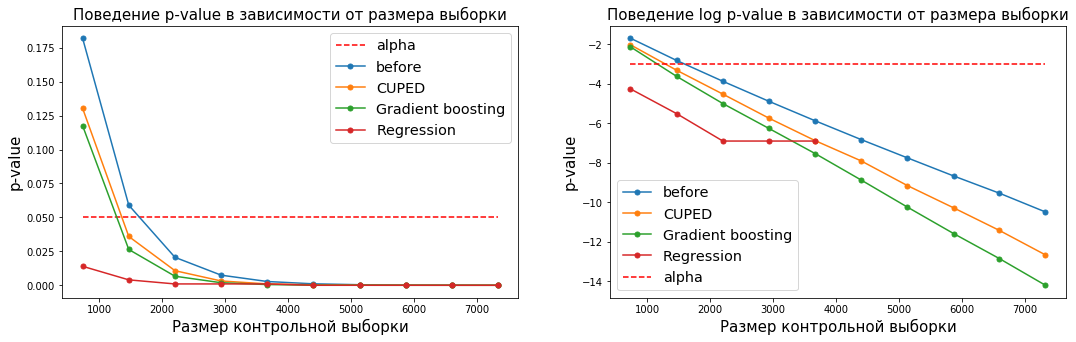

In [82]:
draw_graphics(before, after_cup, after_gb, after_reg, title=f'Большие фолды: {control_indexes_big[0].shape[0]}\nБольшая история: {control_sample_big_hist.shape[0]}')
plt.show()

# Другое тестирование (графики с std)

In [65]:
sizes = [400, 800, 1000, 1200, 1500, 2000]

## Генерация выборки

In [688]:
# all_control = df.loc[(df['treatment'] == 0) & (~df.index.isin(control_sample_hist.index))]
# all_treatment = df.loc[(df['treatment'] == 1) & (~df.index.isin(treatment_sample_hist.index))]
# scale = all_treatment.shape[0] / all_control.shape[0]

# control_generators = []
# treatment_generators = []

# for size in tqdm(sizes):
#     msss_control = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=size, random_state=size + 5)
#     msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=int(size * scale), random_state=size + 5)
    
#     control_generator = msss_control.split(all_control.values, all_control.loc[:, columns].values)
#     treatment_generator = msss_treatment.split(all_treatment.values, all_treatment.loc[:, columns].values)
    
#     control_indexes = list(control_generator)
#     treatment_indexes = list(treatment_generator)
    
    
#     data_control = []
#     data_treatment = []

#     for i in tqdm(range(0, len(control_indexes))):
#         data_control.append(all_control.iloc[control_indexes[i][1]])
#         data_treatment.append(all_treatment.iloc[treatment_indexes[i][1]])
    
#     print(control_indexes[0][1].shape)

# #     joblib.dump(data_control, f'control_data_split_{size}.joblib')
# #     joblib.dump(data_treatment, f'treatment_data_split_{size}.joblib')
    
    

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(400,)


  0%|          | 0/10 [00:00<?, ?it/s]

(800,)


  0%|          | 0/10 [00:00<?, ?it/s]

(1000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(1200,)


  0%|          | 0/10 [00:00<?, ?it/s]

(1500,)


  0%|          | 0/10 [00:00<?, ?it/s]

(2000,)


In [697]:
# history_size = 1000
# history_scale = scale

# for size in tqdm(sizes):
#     control_ind = joblib.load(f'control_data_split_{size}.joblib')
#     treatment_ind = joblib.load(f'treatment_data_split_{size}.joblib')
    
#     all_in_slit_control = []
#     all_in_slit_treatment = []
    
#     for i in range(0, len(control_ind)):
#         all_in_slit_control.extend(control_ind[i].index)
#         all_in_slit_treatment.extend(treatment_ind[i].index)
        
        
#     all_control_for_hist = df.loc[(df['treatment'] == 0) & (~df.index.isin(all_in_slit_control))]
#     all_treatment_for_hist = df.loc[(df['treatment'] == 1) & (~df.index.isin(all_in_slit_treatment))]
     
#     #  Нужна ли стратификация для истории?
#     msss_control = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=history_size, random_state=size + 2)
#     msss_treatment = MultilabelStratifiedShuffleSplit(n_splits=10, test_size=int(history_size * history_scale), random_state=size + 2)
    
#     control_generator = msss_control.split(all_control_for_hist.values, all_control_for_hist.loc[:, columns].values)
#     treatment_generator = msss_treatment.split(all_treatment_for_hist.values, all_treatment_for_hist.loc[:, columns].values)
    
#     control_indexes = list(control_generator)
#     treatment_indexes = list(treatment_generator)
    
#     print(control_indexes[0][1].shape)
    
#     hist_control_table = []
#     hist_treatment_table = []
    
#     for i in range(0, len(control_indexes)):
#         hist_control_table.append(all_control_for_hist.iloc[control_indexes[i][1]])
#         hist_treatment_table.append(all_treatment_for_hist.iloc[treatment_indexes[i][1]])


        
        
#     joblib.dump(hist_control_table, f'control_data_hist_{size}.joblib')
#     joblib.dump(hist_treatment_table, f'treatment_data_hist_{size}.joblib')
    

  0%|          | 0/6 [00:00<?, ?it/s]

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


## Тестирование

In [66]:
def run_test(sample_c, sample_t, history_c_ind, history_t_ind):
    before = []
    after_cup = []
    after_gb = []
    after_reg = []

    cols1 = cols_regr_ordinal#['f2', 'f11', 'f10']#['f4', 'f10']
    cols2 = cols_boosting#['f2', 'f8', 'f10']#['f4', 'f10']
    cols3 = ['f4', 'f11', 'f2']
    
    
    for i in tqdm(range(0, len(sample_c))):
        test_control = sample_c[i]
        test_treatment = sample_t[i]
        
        hist_control = history_c_ind[i]
        hist_treatment = history_t_ind[i]
        
        
        p_bef, p_after_cup = modify_with_cuped(test_control, test_treatment, hist_control, hist_treatment, cols1, True, encoder='Ord')
        p_bef, p_after_gb = modify_with_gb(test_control, test_treatment, hist_control, hist_treatment, cols2)
        p_aft_reg = modify_with_regression_test(test_control, test_treatment, hist_control, hist_treatment, cols3)

        
        before.append(p_bef)
        after_cup.append(p_after_cup)
        after_gb.append(p_after_gb)
        after_reg.append(p_aft_reg)
        
    return np.array(before), np.array(after_cup), np.array(after_gb), np.array(after_reg)

In [67]:
sizes = [400, 800, 1000, 1200, 1500, 2000]

pvals_b = []
pvals_c = []
pvals_gb = []
pvals_reg = []

for size in tqdm(sizes):
    control_ind = joblib.load(f'saved_variables/control_data_split_{size}.joblib')
    treatment_ind = joblib.load(f'saved_variables/treatment_data_split_{size}.joblib')
    
    control_ind_hist = joblib.load(f'saved_variables/control_data_hist_{size}.joblib')
    treatment_ind_hist = joblib.load(f'saved_variables/treatment_data_hist_{size}.joblib')
    
    b, c, gb, reg = run_test(control_ind, treatment_ind, control_ind_hist, treatment_ind_hist)
    
    pvals_b.append(b)
    pvals_c.append(c)
    pvals_gb.append(gb)
    pvals_reg.append(reg)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Control size: 400, Experimental size: 2265
БЫЛО:
p-val: 0.29374495452767996
Статзначимой разницы нет
Стало:
p-val: 0.24509997536840775
Статзначимой разницы нет


Control size: 400, Experimental size: 2265
БЫЛО:
p-val: 0.29374495452767996
Статзначимой разницы нет
Стало:
p-val: 0.20507295205574483
Статзначимой разницы нет


Control size: 400, Experimental size: 2265
Control size: 400, Experimental size: 2265
БЫЛО:
p-val: 0.29374495452767985
Статзначимой разницы нет
Стало:
p-val: 0.2410669031424595
Статзначимой разницы нет


Control size: 400, Experimental size: 2265
БЫЛО:
p-val: 0.29374495452767985
Статзначимой разницы нет
Стало:
p-val: 0.23765266691486625
Статзначимой разницы нет


Control size: 400, Experimental size: 2265
Control size: 400, Experimental size: 2265
БЫЛО:
p-val: 0.29374495452767996
Статзначимой разницы нет
Стало:
p-val: 0.22162916520735074
Статзначимой разницы нет


Control size: 400, Experimental size: 2265
БЫЛО:
p-val: 0.29374495452767996
Статзначимой разницы нет
Стал

  0%|          | 0/10 [00:00<?, ?it/s]

Control size: 800, Experimental size: 4531
БЫЛО:
p-val: 0.19361004032519255
Статзначимой разницы нет
Стало:
p-val: 0.14880806173451833
Статзначимой разницы нет


Control size: 800, Experimental size: 4531
БЫЛО:
p-val: 0.19361004032519255
Статзначимой разницы нет
Стало:
p-val: 0.1320610639683552
Статзначимой разницы нет


Control size: 800, Experimental size: 4531
Control size: 800, Experimental size: 4531
БЫЛО:
p-val: 0.19361004032519255
Статзначимой разницы нет
Стало:
p-val: 0.11043380297160993
Статзначимой разницы нет


Control size: 800, Experimental size: 4531
БЫЛО:
p-val: 0.19361004032519255
Статзначимой разницы нет
Стало:
p-val: 0.102114029949399
Статзначимой разницы нет


Control size: 800, Experimental size: 4531
Control size: 800, Experimental size: 4531
БЫЛО:
p-val: 0.19361004032519255
Статзначимой разницы нет
Стало:
p-val: 0.12914341138467114
Статзначимой разницы нет


Control size: 800, Experimental size: 4531
БЫЛО:
p-val: 0.19361004032519255
Статзначимой разницы нет
Стало:

  0%|          | 0/10 [00:00<?, ?it/s]

Control size: 1000, Experimental size: 5664
БЫЛО:
p-val: 0.11491078814319929
Статзначимой разницы нет
Стало:
p-val: 0.08558918927298698
Статзначимой разницы нет


Control size: 1000, Experimental size: 5664
БЫЛО:
p-val: 0.11491078814319929
Статзначимой разницы нет
Стало:
p-val: 0.06550917545911229
Статзначимой разницы нет


Control size: 1000, Experimental size: 5664
Control size: 1000, Experimental size: 5664
БЫЛО:
p-val: 0.11491078814319929
Статзначимой разницы нет
Стало:
p-val: 0.07192169926089607
Статзначимой разницы нет


Control size: 1000, Experimental size: 5664
БЫЛО:
p-val: 0.11491078814319929
Статзначимой разницы нет
Стало:
p-val: 0.05390632299812268
Статзначимой разницы нет


Control size: 1000, Experimental size: 5664
Control size: 1000, Experimental size: 5664
БЫЛО:
p-val: 0.11491078814319929
Статзначимой разницы нет
Стало:
p-val: 0.07147715751116385
Статзначимой разницы нет


Control size: 1000, Experimental size: 5664
БЫЛО:
p-val: 0.11491078814319929
Статзначимой разницы

  0%|          | 0/10 [00:00<?, ?it/s]

Control size: 1200, Experimental size: 6797
БЫЛО:
p-val: 0.0955795427516023
Статзначимой разницы нет
Стало:
p-val: 0.04852766893978829
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1200, Experimental size: 6797
БЫЛО:
p-val: 0.0955795427516023
Статзначимой разницы нет
Стало:
p-val: 0.04449135856699182
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1200, Experimental size: 6797
Control size: 1200, Experimental size: 6797
БЫЛО:
p-val: 0.0955795427516023
Статзначимой разницы нет
Стало:
p-val: 0.05522065192690417
Статзначимой разницы нет


Control size: 1200, Experimental size: 6797
БЫЛО:
p-val: 0.0955795427516023
Статзначимой разницы нет
Стало:
p-val: 0.051147444973084266
Статзначимой разницы нет


Control size: 1200, Experimental size: 6797
Control size: 1200, Experimental size: 6797
БЫЛО:
p-val: 0.0955795427516023
Статзначимой разницы нет
Стало:
p-val: 0.06117300198985729
Статзначимой разницы нет


Control s

  0%|          | 0/10 [00:00<?, ?it/s]

Control size: 1500, Experimental size: 8496
БЫЛО:
p-val: 0.05477820684879427
Статзначимой разницы нет
Стало:
p-val: 0.03543379907356506
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1500, Experimental size: 8496
БЫЛО:
p-val: 0.05477820684879427
Статзначимой разницы нет
Стало:
p-val: 0.026158286860406065
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1500, Experimental size: 8496
Control size: 1500, Experimental size: 8496
БЫЛО:
p-val: 0.05477820684879427
Статзначимой разницы нет
Стало:
p-val: 0.03520467801748792
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1500, Experimental size: 8496
БЫЛО:
p-val: 0.05477820684879427
Статзначимой разницы нет
Стало:
p-val: 0.02376986686774125
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 1500, Experimental size: 8496
Control size: 1500, Experimental size: 8496
БЫЛО:
p-val: 0.0547782068487942

  0%|          | 0/10 [00:00<?, ?it/s]

Control size: 2000, Experimental size: 11329
БЫЛО:
p-val: 0.02579400905295038
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.00989016753272553
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2000, Experimental size: 11329
БЫЛО:
p-val: 0.02579400905295038
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.005731380809728634
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2000, Experimental size: 11329
Control size: 2000, Experimental size: 11329
БЫЛО:
p-val: 0.02579400905295038
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.010282323676922656
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)


Control size: 2000, Experimental size: 11329
БЫЛО:
p-val: 0.02579400905295038
Стат. значимая разница (отвергли нулевую гипотезу о равенстве средних)
Стало:
p-val: 0.006510720962841942
С

In [68]:
pvals_c = pd.DataFrame(pvals_c)
pvals_c = pvals_c.set_axis(sizes)

pvals_gb = pd.DataFrame(pvals_gb)
pvals_gb = pvals_gb.set_axis(sizes)

pvals_b = pd.DataFrame(pvals_b)
pvals_b = pvals_b.set_axis(sizes)

pvals_reg = pd.DataFrame(pvals_reg)
pvals_reg = pvals_reg.set_axis(sizes)

In [69]:
data_cuped = None
for i in range(pvals_c.shape[1]):
    data_cuped = pd.concat([data_cuped, pvals_c.iloc[:, i]])
    
data_grad_boost = None
for i in range(pvals_gb.shape[1]):
    data_grad_boost = pd.concat([data_grad_boost, pvals_gb.iloc[:, i]])
    
    
data_before = None
for i in range(pvals_b.shape[1]):
    data_before = pd.concat([data_before, pvals_b.iloc[:, i]])

data_reg = None
for i in range(pvals_reg.shape[1]):
    data_reg = pd.concat([data_reg, pvals_reg.iloc[:, i]])

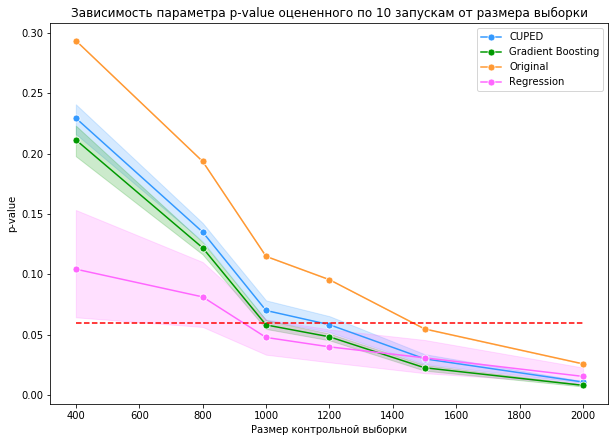

In [76]:
f = plt.subplots(1, figsize=(10, 7))
sns.lineplot(data=data_cuped, label='CUPED', marker="o", markersize=7, color='#3399ff')
sns.lineplot(data=data_grad_boost, label='Gradient Boosting', marker="o", markersize=7, color='#009900')
sns.lineplot(data=data_before, label='Original', marker="o", markersize=7, color='#ff9933')
sns.lineplot(data=data_reg, label='Regression', marker="o", markersize=7, color='#ff66ff')
plt.plot(sizes, [0.05] * len(sizes), color="#ff0000", linestyle='dashed', label='alpha')
plt.title('Зависимость параметра p-value оцененного по 10 запускам от размера выборки')
plt.xlabel('Размер контрольной выборки')
plt.ylabel('p-value')

plt.show()